In [3]:
from gymnasium.wrappers import FrameStackObservation
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from collections import deque
from datetime import datetime
from pathlib import Path
import gymnasium as gym
from tqdm import tqdm
from PIL import Image
import numpy as np
import random
import ale_py
import time
import cv2
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from utils import *

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")

device: cpu


In [5]:
def remake_env(render_mode=None):
    global env
    if 'env' in globals(): 
        env.close()
        del env
    env = gym.make('BreakoutDeterministic-v4', render_mode=render_mode)
    env = FrameStackObservation(env, 4)  # stack previous 4 frames to simulate motion and mend Markov property
remake_env(None)

In [12]:
checkpoint_file, checkpoint_version = get_checkpoint(71)
assert checkpoint_file is not None

online_net = QNetwork()
online_net.load_state_dict(torch.load('./checkpoints/' + checkpoint_file, weights_only=True, map_location=torch.device(device))['online_state_dict'])

print('loaded', checkpoint_file)

loaded 82-breakout_feb_27-74324e-25922087s.pth


In [13]:
epsilon = 0.1
reward_clip = (-1, 1)

In [14]:
def greedy(state):
    return online_net(state).argmax().item()

In [15]:
def epsilon_greedy(state):
    if np.random.random() < epsilon:
        return env.action_space.sample()
    return greedy(state)

In [16]:
remake_env('human')

state, info = env.reset()
state = preprocess_state(state)

noop_limit = 30  # force firing of ball if X noops in a row
noop_count = 0
step = 0

try:
    while True:
        step += 1
        action = epsilon_greedy(state)
        # action = greedy(state)
        noop_count = noop_count + 1 if action == 0 else 0    
        if noop_count >= noop_limit:
            action = 1
            noop_count = 0
        state, raw_reward, terminated, truncated, info = env.step(action)
        reward = np.clip(raw_reward, *reward_clip)
        
        state = preprocess_state(state)
    
        clear_output(wait=True)
        print(f'step {step}, took action {action}, got raw reward {raw_reward} (clipped {reward})')
        
        if terminated or truncated:
            break
            
except KeyboardInterrupt:
    print('kb interrupt')
finally:
    remake_env(None)
    state, info = env.reset()
    env.close()

step 378, took action 1, got raw reward 0.0 (clipped 0.0)
kb interrupt


(32, 20, 20) 
 (20, 20)


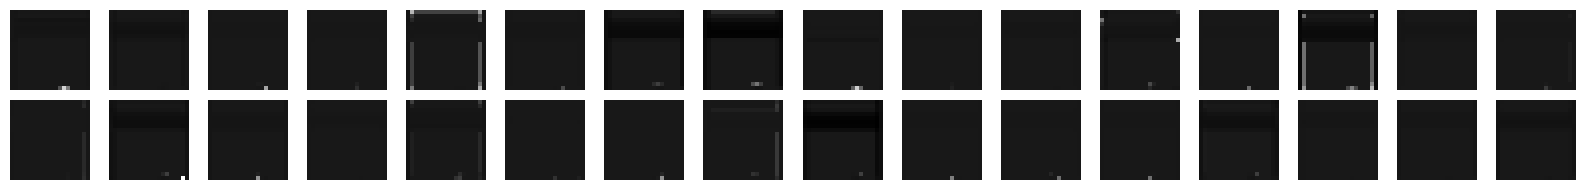

In [30]:
# what the network sees after 1st conv layer and relu (32 filters with 8x8 kernel, stride of 4)
# each resulting box is a 20x20 image
with torch.no_grad():
    x = preprocess_state(state)
    x = x / 255.0
    x = online_net.conv1(x)
    x = F.leaky_relu(x)
    x = np.array(x).squeeze(0)
    x = (x - x.min()) / (x.max() - x.min()) * 255.0  # min-max scaling for clarity
print(x.shape, '\n', x[0].shape)
fig, axes = plt.subplots(2, 16, figsize=(16, 2))
for i in range(32):
    axes[i // 16, i % 16].imshow(Image.fromarray(x[i]))
    axes[i // 16, i % 16].axis('off')
plt.tight_layout(), plt.show();

(64, 9, 9) 
 (9, 9)


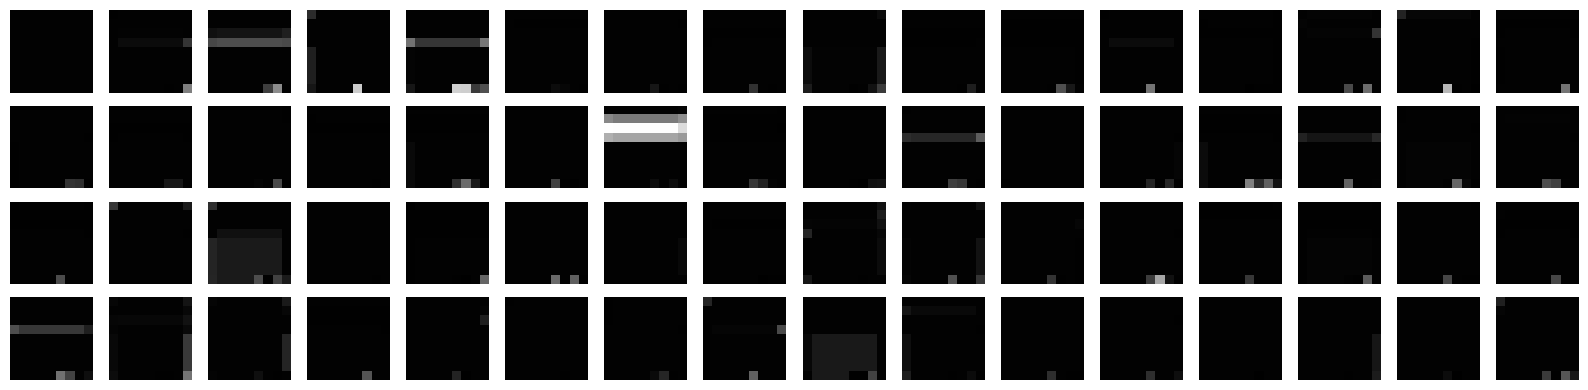

In [31]:
# what the network sees after 2nd conv layer and relu (64 filters with 4x4 kernel, stride of 2)
# each resulting box is a 9x9 image
with torch.no_grad():
    x = preprocess_state(state)
    x = x / 255.0
    x = online_net.conv1(x)
    x = F.leaky_relu(x)
    x = online_net.conv2(x)
    x = F.leaky_relu(x)
    x = np.array(x).squeeze(0)
    x = (x - x.min()) / (x.max() - x.min() + 1e-7) * 255.0  # min-max scaling for clarity
print(x.shape, '\n', x[0].shape)
fig, axes = plt.subplots(4, 16, figsize=(16, 4))
for i in range(64):
    axes[i // 16, i % 16].imshow(Image.fromarray(x[i]))
    axes[i // 16, i % 16].axis('off')
plt.tight_layout(), plt.show();

(64, 7, 7) 
 (7, 7)


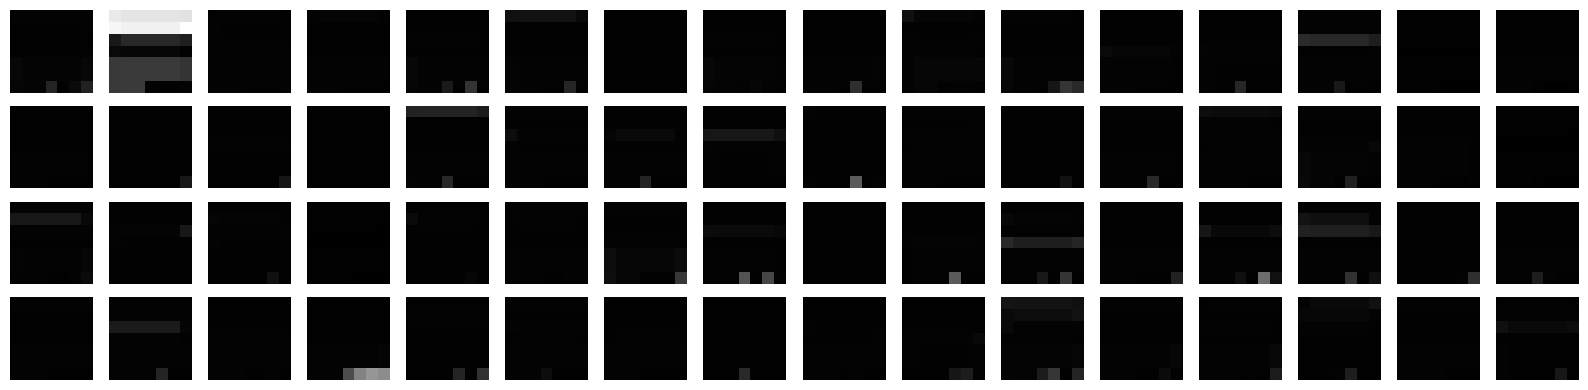

In [32]:
# what the network sees after 3rd conv layer and relu (64 filters with 3x3 kernel, stride of 1)
# each resulting box is a 7x7 image
with torch.no_grad():
    x = preprocess_state(state)
    x = x / 255.0
    x = online_net.conv1(x)
    x = F.leaky_relu(x)
    x = online_net.conv2(x)
    x = F.leaky_relu(x)
    x = online_net.conv3(x)
    x = F.leaky_relu(x)
    x = np.array(x).squeeze(0)
    x = (x - x.min()) / (x.max() - x.min() + 1e-7) * 255.0  # min-max scaling for clarity
print(x.shape, '\n', x[0].shape)
fig, axes = plt.subplots(4, 16, figsize=(16, 4))
for i in range(64):
    axes[i // 16, i % 16].imshow(Image.fromarray(x[i]))
    axes[i // 16, i % 16].axis('off')
plt.tight_layout(), plt.show();

In [21]:
x  # min-max scaled to fc layer

array([[[  8.68842  ,   8.574558 ,   8.574558 , ...,   8.574558 ,
           8.574558 ,   8.405884 ],
        [  6.9455366,   7.233394 ,   7.233394 , ...,   7.233394 ,
           7.233394 ,   7.299668 ],
        [  6.668623 ,   7.123705 ,   7.123705 , ...,   7.123705 ,
           7.123705 ,   7.4669533],
        ...,
        [  8.914855 ,   8.843936 ,   8.843936 , ...,   8.843936 ,
           8.843936 ,   8.996466 ],
        [  8.914855 ,   8.843936 ,   8.843936 , ...,   8.843936 ,
           8.843936 ,   8.996466 ],
        [  8.915793 ,   8.843936 ,   8.843936 , ...,   8.235232 ,
           8.513787 ,   8.990895 ]],

       [[181.31587  , 175.90535  , 175.90535  , ..., 175.90535  ,
         175.90535  , 175.16794  ],
        [173.45439  , 162.27055  , 162.27055  , ..., 162.27055  ,
         162.27055  , 152.71872  ],
        [  6.2700562,   7.1775556,   7.1775556, ...,   7.1775556,
           7.1775556,   5.94719  ],
        ...,
        [  9.014856 ,   9.034701 ,   9.034701 , ...,  